In [5]:
import ezdxf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def plot_street(ax,linewidth=1, shadow_map=True):
    # Load the DXF file
    dxf_file = 'assets/street_small.dxf'
    doc = ezdxf.readfile(dxf_file)

    # Get the modelspace
    msp = doc.modelspace()
    x_min, y_min = float('inf'), float('inf')
    x_max, y_max = float('-inf'), float('-inf')
    
    # Iterate over all entities in the modelspace
    for entity in msp:
        if entity.dxftype() == 'POLYLINE':
            points = entity.points()
            x_coords = []
            y_coords = []
            for point in points:
                x_coords.append(point[0])
                y_coords.append(point[1]-1)
                # Update bounds
                x_min = min(x_min, point[0])
                y_min = min(y_min, point[1])
                x_max = max(x_max, point[0])
                y_max = max(y_max, point[1])

            x_coords.append(x_coords[0])
            y_coords.append(y_coords[0])
            if not shadow_map:
                ax.plot(x_coords, y_coords, color='black', linewidth=linewidth)
    # Set equal scaling
    ax.set_aspect('equal')
    ax.set_axis_off()
    if shadow_map:
        #load the render image
        img = plt.imread('assets/map_small.png')
        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min-0.9), x_max-x_min-0.1, y_max-y_min+0.9, linewidth=1, edgecolor='black', facecolor='none')

        # Add the rectangle to the Axes
        ax.imshow(img, extent=[x_min, x_max, y_min-1, y_max])
        ax.add_patch(rect)
    return ax

In [6]:
import os
import json

def read_log_file(log_file):
    path = []
    actions = []
    data = {}
    with open(log_file,'r') as f:
        data = json.load(f)
    for key, value in data.items():
        logs = value['logs']
        action = logs.get('action')
        position = logs.get('position')
        if position:
            act = None
            coord = json.loads(position['message'])['position']
            path.append([coord['x'],coord['z']*-1])
            if action:
                act = json.loads(action['message'])['action']
            actions.append(act)  
    return path,actions


In [7]:

def draw_path(ax, log_dir = 'logs', 
              experiment = 'base', color='blue', line_width=2,line_alpha=0.7,shadow_map=True):
    folder_list = [os.path.join(log_dir,f) for f in os.listdir(log_dir) if experiment in f]
    folder_list = [f for f in folder_list if os.path.isdir(f)]
    ax = plot_street(ax,linewidth=1, shadow_map=shadow_map)
    success_count = 0
    failed_count = 0
    for folder in folder_list:
        log_file = os.path.join(folder, 'logs.json')
        path,actions = read_log_file(log_file)
        path = np.array(path)
        success = False
        for i in range(len(path)):
            if actions[i] == 'finish':
                success = True
                success_count += 1
                # plot finish point
                ax.plot(path[i, 0], path[i, 1], color=color, marker='o', markersize=5,label='Success Path' if success_count ==1 else "")
                # plot sucess path before found the train station
                ax.plot(path[:i+1, 0], path[:i+1, 1], color=color, linewidth=line_width,alpha=line_alpha)
                # plot sub task path after found the train station
                ax.plot(path[i:, 0], path[i:, 1], color=color, linewidth=line_width, linestyle='dashed', label='Sub Task Path' if success_count ==1 else "")
        if not success:
            failed_count += 1
            # plot fail path
            ax.plot(path[:, 0], path[:, 1], color='red', linewidth=line_width,alpha=line_alpha)
            # plot fail end point
            ax.plot(path[-1, 0], path[-1, 1], color='red', marker='x', markersize=5,label='Failed Path' if failed_count==1 else "")
    ax.legend(loc='lower right',prop={'size': 18})
    ax.set_title(f'Paths ({experiment})', fontsize=30)
    return ax

In [8]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def hex2rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


def draw_decision_points(ax, log_dir = 'logs', 
                         experiment = 'base', color='blue',cmap='Blues',alpha=0.8,shadow_map=True):
    folder_list = [os.path.join(log_dir,f) for f in os.listdir(log_dir) if experiment in f]
    folder_list = [f for f in folder_list if os.path.isdir(f)]
    paths = []
    ax = plot_street(ax,linewidth=1, shadow_map=shadow_map)
    for folder in folder_list:
        success = False
        log_file = os.path.join(folder, 'logs.json')
        path,actions = read_log_file(log_file)
        # exclude the sub task path
        for i in range(len(path)):
            if actions[i] == 'finish':
                success = True
                paths.append(path[:i])
                break
        if not success:
            paths.append(path)

    paths = np.vstack(paths)
    rgb_color = hex2rgb(color)
    colors = [(rgb_color[0], rgb_color[1], rgb_color[2], alpha) for alpha in np.linspace(0, 1, 5)]
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=5)
    sns.scatterplot(x=paths[:, 0],y=paths[:, 1],color=color,alpha=alpha, label="Decision Points",ax=ax)
    sns.kdeplot(x=paths[:, 0],y=paths[:, 1], cmap=cmap, fill=True, thresh=0.01,alpha=0.5, ax=ax)
    ax.legend(loc='lower right',prop={'size': 18})
    ax.set_title(f'Decision Points ({experiment})', fontsize=30)
    return ax

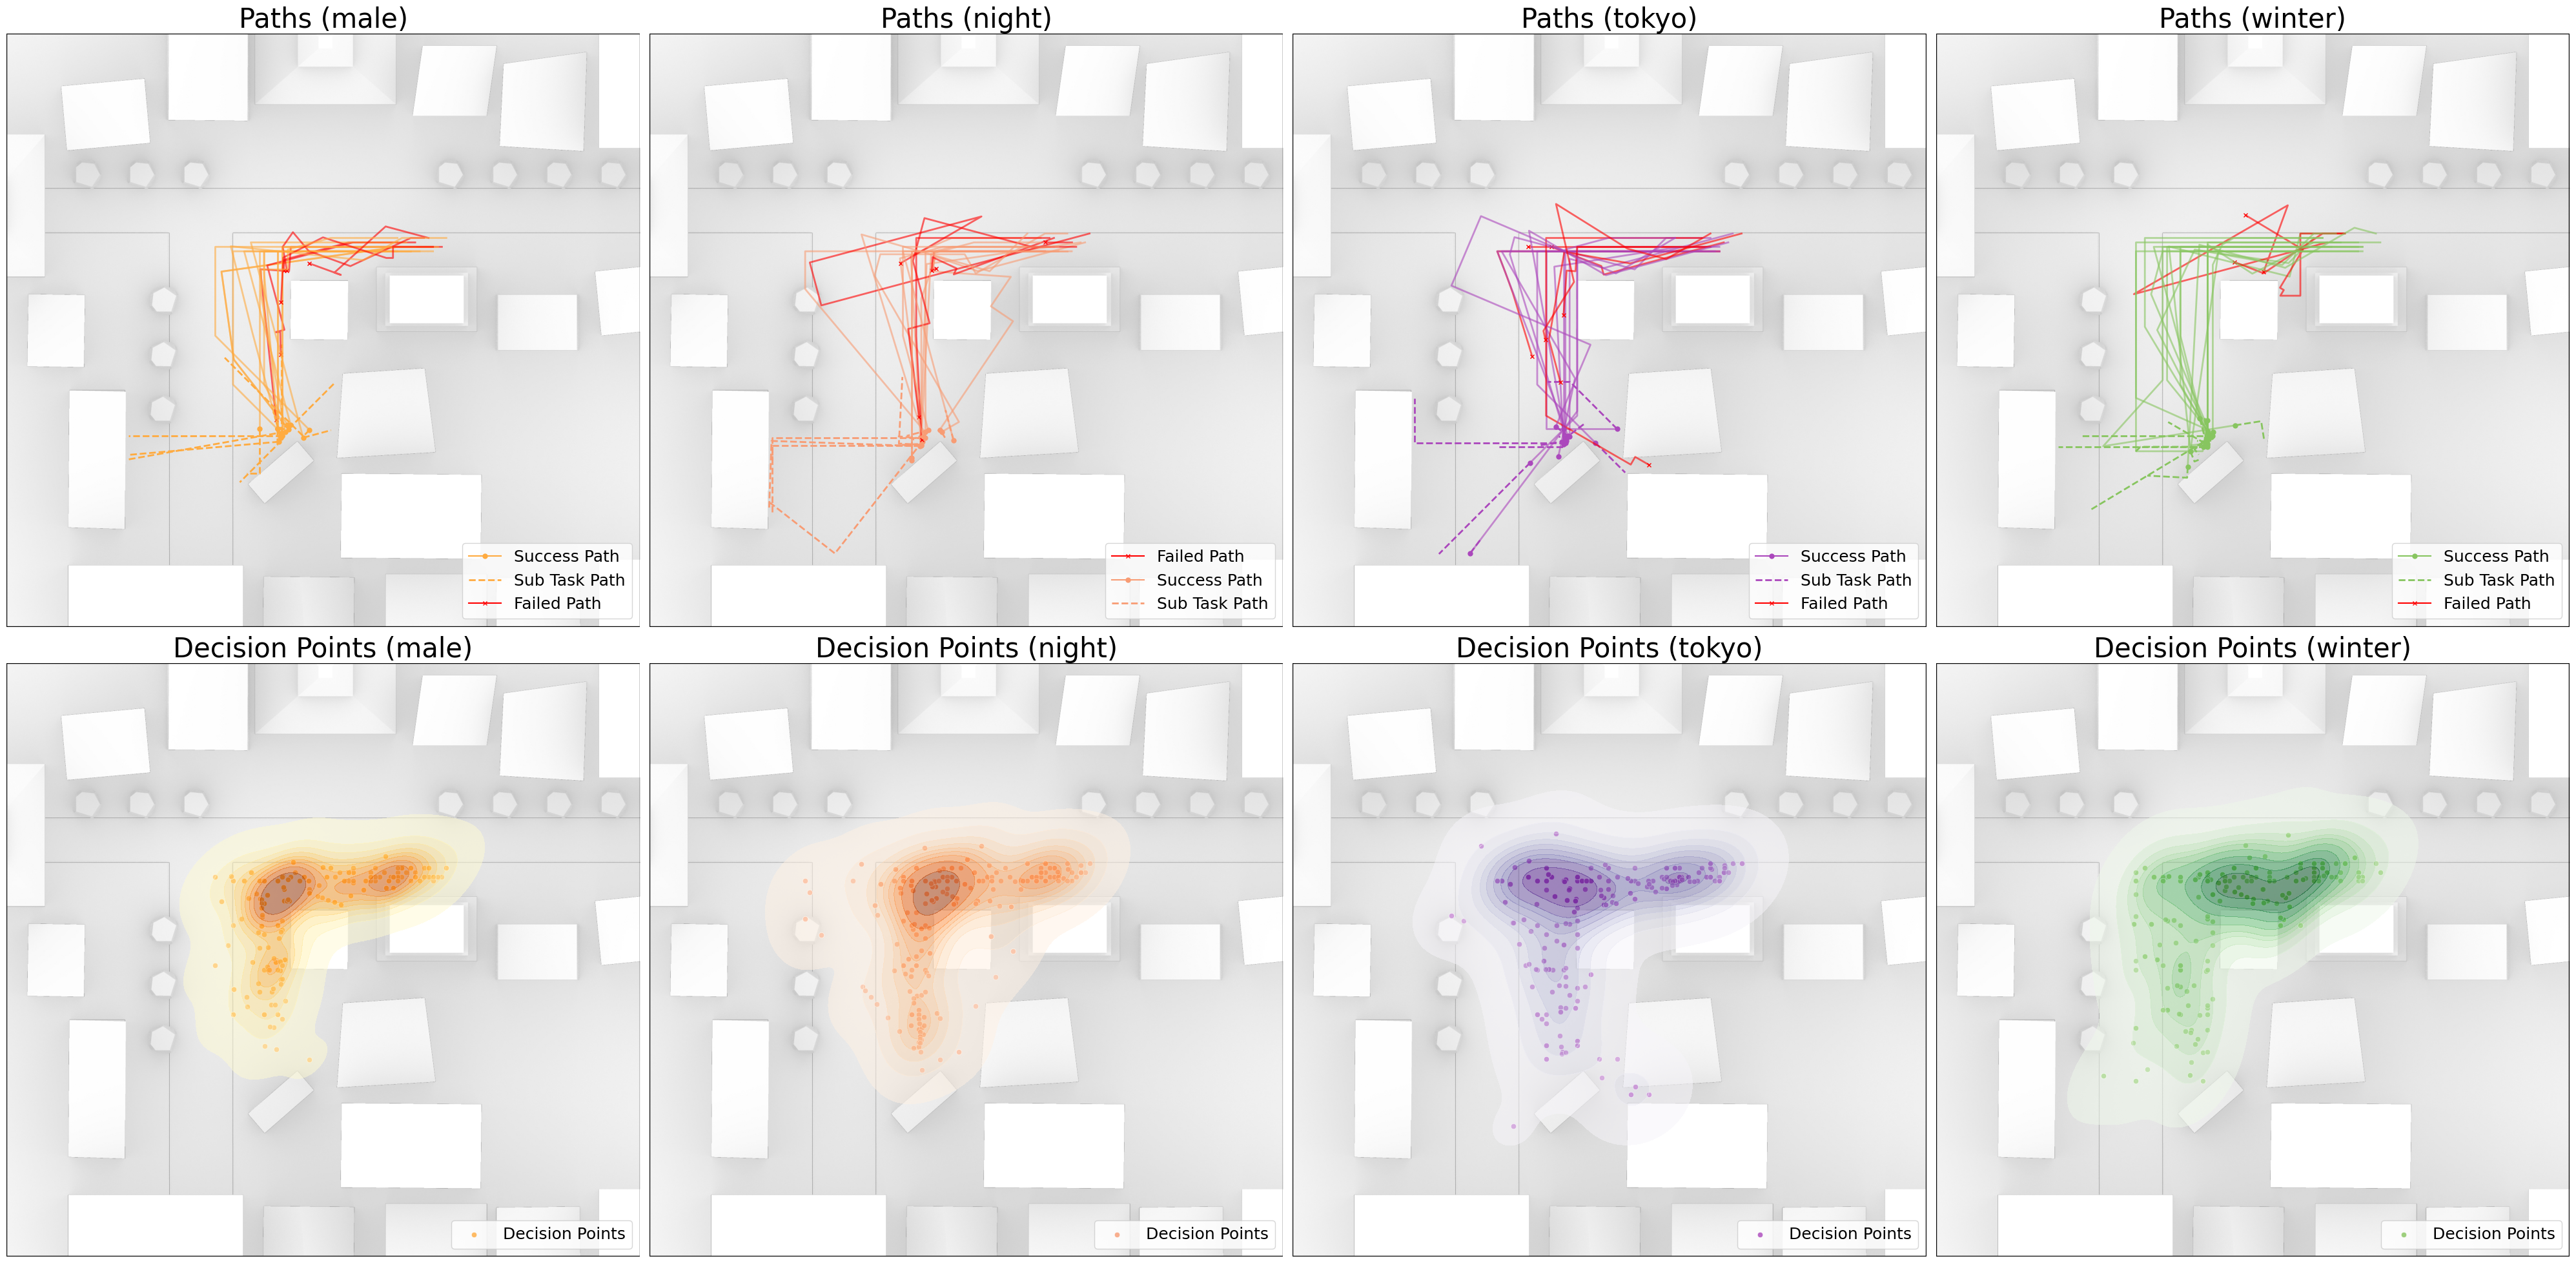

In [9]:
fig, axs = plt.subplots(figsize=(40,20),nrows=2,ncols=4)
axs = axs.flatten()
experiments = ['male','night','tokyo','winter']
colors = ['#ffab40','#f89c74','#ab47bc','#87c55f']
cmaps = ['YlOrBr','Oranges','Purples','Greens']
for i, experiment in enumerate(experiments):
    draw_path(axs[i], experiment=experiments[i], color=colors[i],line_width=2,line_alpha=0.6,shadow_map=True)
    draw_decision_points(axs[i+4], experiment=experiments[i], color=colors[i],cmap=cmaps[i],alpha=0.8,shadow_map=True)
plt.tight_layout()
plt.show()

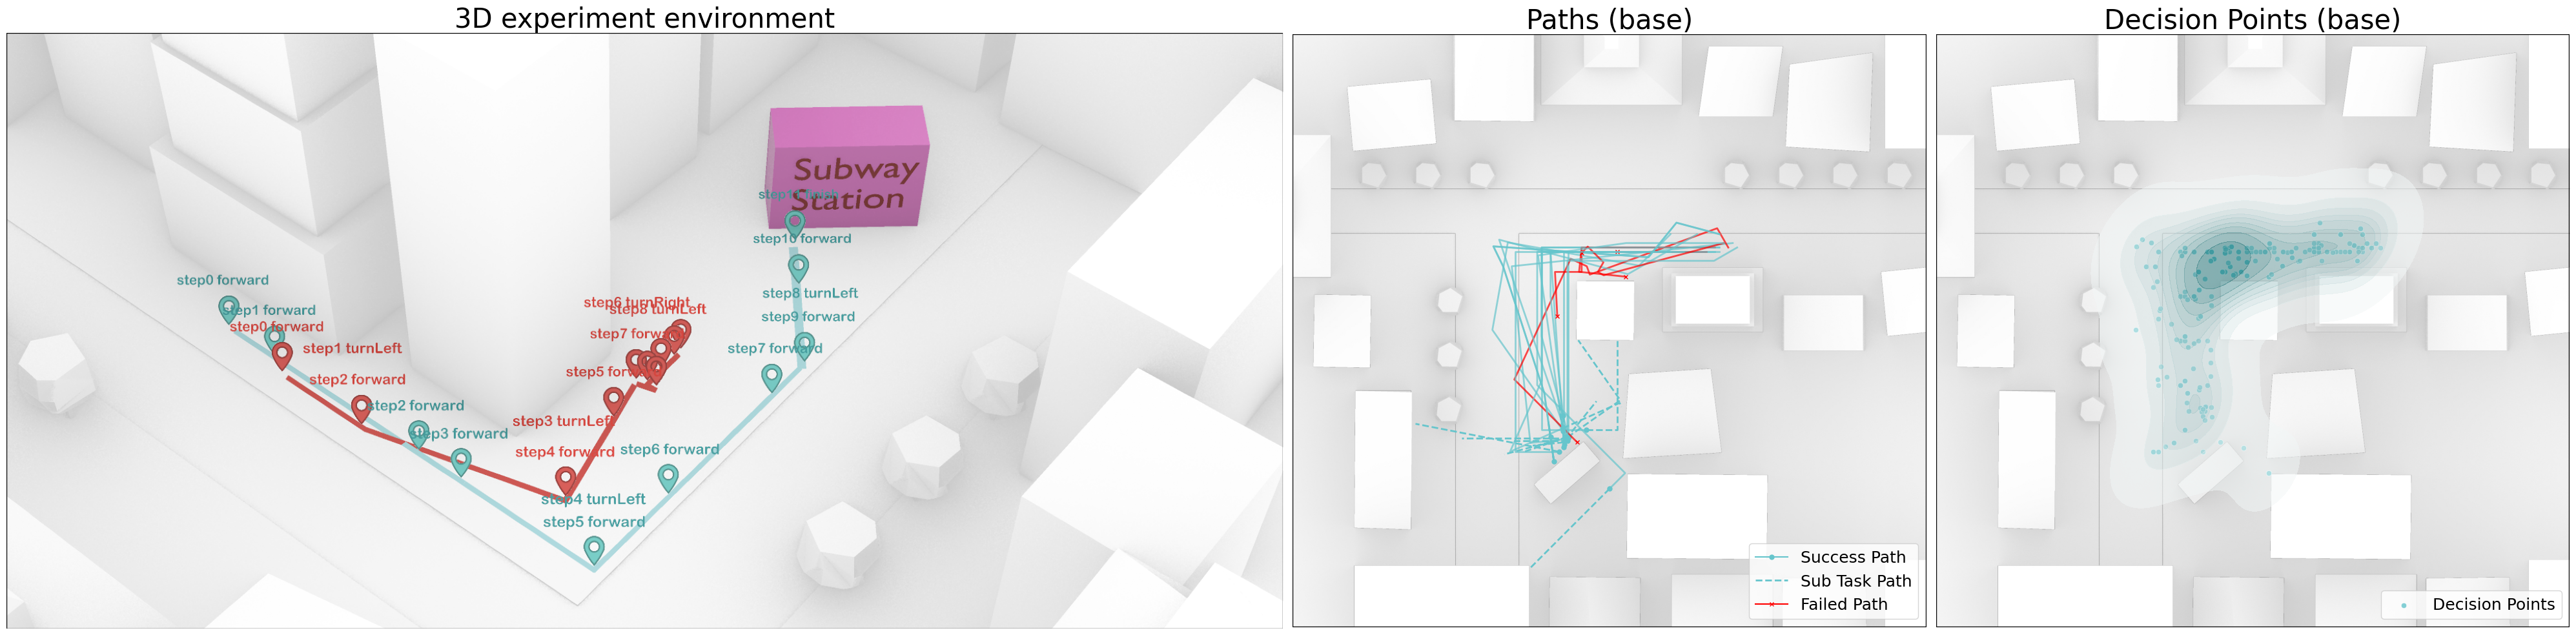

In [10]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(40,10))
gs = gridspec.GridSpec(1, 4)

ax1 = fig.add_subplot(gs[0, 0:2])
img = plt.imread('assets/isolate_view.png')
ax1.imshow(img, extent=[0, 21, 0, 9.8])
path = np.array([[0, 0], [21, 0], [21, 9.8], [0, 9.8], [0, 0]])
ax1.plot(path[:, 0], path[:, 1], color='black', linewidth=1)
ax1.set_title(f'3D experiment environment', fontsize=30)
ax1.axis('off')


color = "#66c5cc"
# cmap = "Blues"
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0, (1, 1, 1, 0)), (1, mcolors.to_rgba("#006064"))])
experiment="base"
ax2 = fig.add_subplot(gs[0, 2])
draw_path(ax2, experiment=experiment, color=color,shadow_map=True)

ax3 = fig.add_subplot(gs[0, 3])
draw_decision_points(ax3, experiment=experiment, color=color,cmap=cmap,alpha=0.8,shadow_map=True)

plt.tight_layout()
plt.show()